In [47]:

!pip install --quiet google-cloud-aiplatform wordcloud seaborn nltk scikit-learn imbalanced-learn 




In [69]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE # Ensure this import is present
from imblearn.pipeline import Pipeline # New import for pipeline

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)



In [70]:
# =========================
# 2) Authenticate & init Vertex AI
# =========================


PROJECT_ID = "our-pursuit-426205-c0"   # 👈 replace with your GCP project
LOCATION = "us-central1"             # or another supported region

import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

from vertexai.preview.generative_models import GenerativeModel

# Load Gemini 1.5 Flash (fast, free quota)
gemini_model = GenerativeModel("gemini-2.5-flash-lite")



In [71]:
# =========================
# 3) Load dataset
# =========================


df = pd.read_csv("amazon_alexa.tsv", delimiter="\t")
print("Shape:", df.shape)
df.head()



Shape: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


Shape: (3150, 5)

Nulls:
 rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


,rating,date,variation,verified_reviews,feedback
count,3150.000000,3150,3150,3149,3150.000000
unique,NaN,77,16,2300,NaN
top,NaN,30-Jul-18,Black Dot,,NaN
freq,NaN,1603,516,79,NaN
mean,4.463175,NaN,NaN,NaN,0.918413
std,1.068506,NaN,NaN,NaN,0.273778
min,1.000000,NaN,NaN,NaN,0.000000
25%,4.000000,NaN,NaN,NaN,1.000000
50%,5.000000,NaN,NaN,NaN,1.000000
75%,5.000000,NaN,NaN,NaN,1.000000


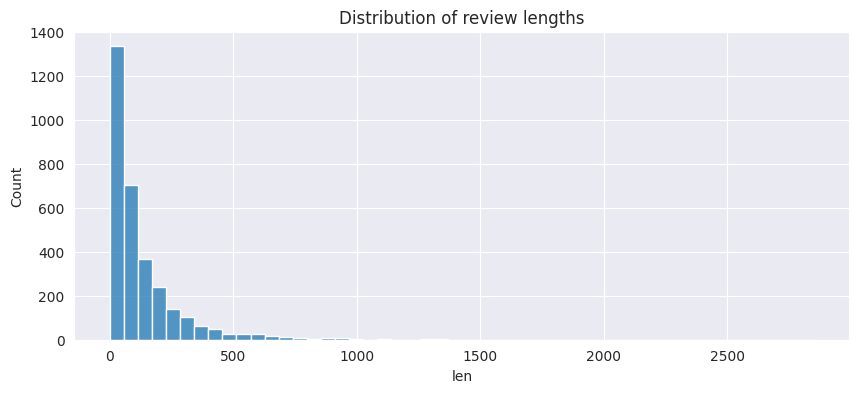

In [72]:
# =========================
# 4) Quick EDA
# =========================
print('Shape:', df.shape)
print('\nNulls:\n', df.isnull().sum())
display(df.describe(include='all'))

# add length column and plot distribution
df['len'] = df['verified_reviews'].fillna('').map(len) # Fill missing values with empty string
plt.figure(figsize=(10,4))
sns.histplot(df['len'], bins=50)
plt.title('Distribution of review lengths')
plt.show()



In [73]:
# =========================
# 5) Text preprocessing
# =========================
ps = PorterStemmer()
nltk.download('stopwords')
sw = set(stopwords.words('english'))
if 'not' in sw:
    sw.remove('not')

c = []
for i in range(len(df)):
    review = df['verified_reviews'].iloc[i]
    if isinstance(review, str):  # Check if the review is a string
        r = re.sub('[^a-zA-Z]', ' ', review)
        r = r.lower()
        r = r.split()
        r = [ps.stem(word) for word in r if word not in sw]
        r = ' '.join(r)
        c.append(r)
    else:
        c.append('') # Append an empty string for non-string values

df['clean_review'] = c
df['clean_review'].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                            love echo
1                                                 love
2    sometim play game answer question correctli al...
3    lot fun thing yr old learn dinosaur control li...
4                                                music
Name: clean_review, dtype: object

In [74]:
# =========================
# 6) Feature extraction & split
# =========================
count_vector = CountVectorizer(max_features=2500)
X = count_vector.fit_transform(df["clean_review"]).toarray()
y = df["feedback"].values

X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(
    X, y, df["verified_reviews"], test_size=0.25, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2362, 2500) Test shape: (788, 2500)


In [82]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [83]:
pipeline.fit(X_train, y_train)
pred_baseline = pipeline.predict(X_test)

print("=== Baseline RF ===")
print(classification_report(y_test, pred_baseline))

=== Baseline RF ===
              precision    recall  f1-score   support

           0       0.59      0.51      0.54        73
           1       0.95      0.96      0.96       715

    accuracy                           0.92       788
   macro avg       0.77      0.74      0.75       788
weighted avg       0.92      0.92      0.92       788



In [84]:
param_grid = {
    "classifier__bootstrap": [True],
    "classifier__max_depth": [60, 80],
    "classifier__min_samples_split": [4, 8],
    "classifier__min_samples_leaf": [2, 4], # Added to param_grid
    "classifier__n_estimators": [100, 200]
}

# Optimize for f1_weighted to account for class imbalance
grid_cv = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring="f1_weighted")
grid_cv.fit(X_train, y_train)

print("Best params:", grid_cv.best_params_)
rf_cv = grid_cv.best_estimator_
pred_tuned = rf_cv.predict(X_test)
print("=== Tuned RF ===")
print(classification_report(y_test, pred_tuned))


Best params: {'classifier__bootstrap': True, 'classifier__max_depth': 60, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 200}
=== Tuned RF ===
              precision    recall  f1-score   support

           0       0.37      0.36      0.36        73
           1       0.93      0.94      0.94       715

    accuracy                           0.88       788
   macro avg       0.65      0.65      0.65       788
weighted avg       0.88      0.88      0.88       788



In [78]:
def llm_classify_vertex(review):
    """
    Classify sentiment using Vertex AI Gemini.
    Returns: 1 -> positive, 0 -> negative
    """
    prompt = f"""You are a content moderation assistant.
Classify the following user review as either NEGATIVE or POSITIVE sentiment.
Return only "NEGATIVE" or "POSITIVE".

Review: "{review}"
"""
    response = gemini_model.generate_content(prompt)
    out = response.candidates[0].content.parts[0].text.strip().upper()
    return 1 if "POSITIVE" in out else 0

# Simple mock fallback if Gemini fails
def llm_classify_mock(message):
    NEG_WORDS = ["hate","terrible","awful","bad","worst","disappointed","broken","useless","poor"]
    msg = message.lower()
    return 0 if any(w in msg for w in NEG_WORDS) else 1

def llm_classify(message):
    try:
        return llm_classify_vertex(message)
    except Exception as e:
        print("Gemini failed, using mock:", e)
        return llm_classify_mock(message)

In [86]:
def hybrid_predict_raw(message, model, vectorizer, threshold=0.70):
    """
    Use RF first, fallback to Gemini if confidence < threshold.
    """
    # The pipeline is now the main model, it handles scaling and classification
    X_vec = vectorizer.transform([message]).toarray()
    probs = model.predict_proba(X_vec)[0]
    pred = model.predict(X_vec)[0]
    if max(probs) < threshold:
        return llm_classify(message)
    return pred

=== Hybrid RF + Gemini ===
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        73
           1       0.97      0.94      0.95       715

    accuracy                           0.92       788
   macro avg       0.75      0.81      0.78       788
weighted avg       0.93      0.92      0.92       788



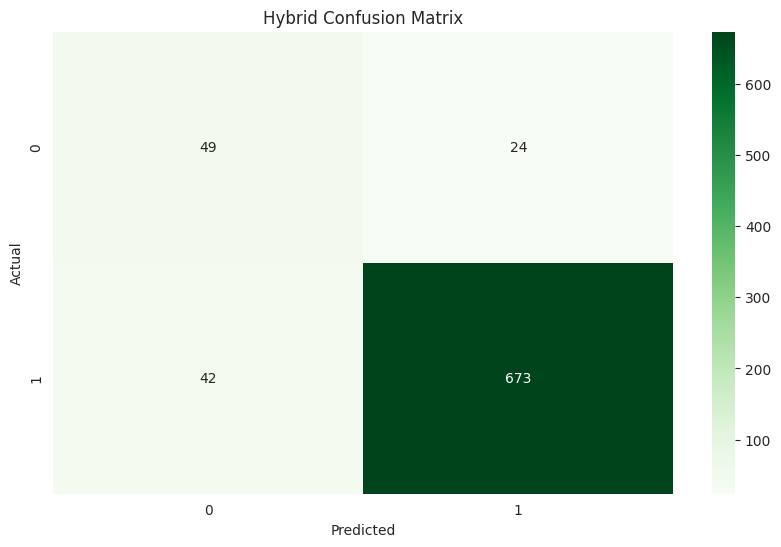

In [88]:
model_to_use = rf_cv
# Keep the threshold at 0.70 to improve precision
threshold = 0.70
hybrid_preds = [hybrid_predict_raw(text, model_to_use, count_vector, threshold)
                for text in text_test]

print("=== Hybrid RF + Gemini ===")
print(classification_report(y_test, hybrid_preds))

cm = confusion_matrix(y_test, hybrid_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Hybrid Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

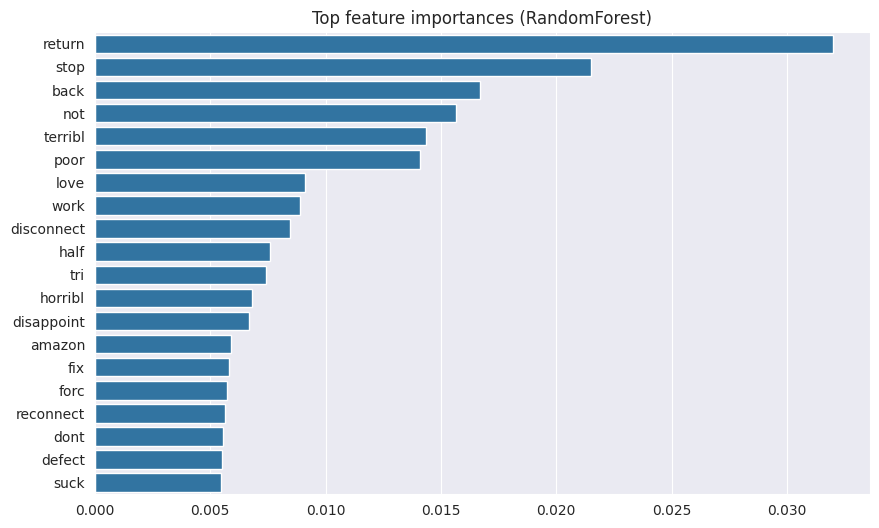

In [33]:
# =========================
# 12) Feature importance (RF)
# =========================
fi = model_to_use.feature_importances_
feature_names = count_vector.get_feature_names_out()
top_idx = fi.argsort()[::-1][:20]

plt.figure(figsize=(10,6))
sns.barplot(x=fi[top_idx], y=feature_names[top_idx])
plt.title("Top feature importances (RandomForest)")
plt.show()
